In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import catboost

In [2]:
df = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

# 목차

## 1. 전처리

* 컬럼 확인
* 결측값 확인
* FeatureImportance 확인

## 2. 모델링

* RandomForestRegressor
* CatBoostRegressor
* PCA

In [3]:
df

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,SESSION_252284,USER_206021,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NaN,Category5_Path_0032
252285,SESSION_252285,USER_206022,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252287,SESSION_252287,USER_206023,1.0,Android Webview,Android,mobile,1,1.0,28.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0018


sessionID : 세션 ID

userID : 사용자 ID

TARGET : 세션에서 발생한 총 조회수

browser : 사용된 브라우저

OS : 사용된 기기의 운영체제

device : 사용된 기기

new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)

quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)

duration : 총 세션 시간 (단위: 초)

bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)

transaction : 세션 내에서 발생의 거래의 수

transaction_revenue : 총 거래 수익

continent : 세션이 발생한 대륙

subcontinent : 세션이 발생한 하위 대륙

country : 세션이 발생한 국가

traffic_source : 트래픽이 발생한 소스

traffic_medium : 트래픽 소스의 매체

keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정

referral_path : traffic_medium이 referral인 경우 설정되는 경로

## 컬럼값 확인

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [5]:
print(df.isna().sum(), df_test.isna().sum(), sep='\n')

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64
sessionID                  0
userID                     0
browser                    0
OS                         0
device                     0
new                        0
quality                    0
duration                   0
bounced                    0
transaction                0
transaction_revenue        0
continent                  0
subcontinent               0
country                    0
traffic_sou

In [6]:
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


In [7]:
df['browser'].value_counts()

browser
Chrome                                                  174395
Safari                                                   35689
Android Webview                                          13855
Firefox                                                   8436
Internet Explorer                                         4573
                                                         ...  
eosutpkiahjzvdgcwxlmyfqbrn                                   1
;__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d5b59;         1
wvsmagudcqeytijorlhxnfzkbp                                   1
efkaxnbyohqtspzlvcwrjmigdu                                   1
NokiaC7-00                                                   1
Name: count, Length: 70, dtype: int64

In [8]:
# 브라우저 종류 확인
for browser_name, count in df['browser'].value_counts().items():
    print(f'Browser: {browser_name}, Count: {count}')

Browser: Chrome, Count: 174395
Browser: Safari, Count: 35689
Browser: Android Webview, Count: 13855
Browser: Firefox, Count: 8436
Browser: Internet Explorer, Count: 4573
Browser: Edge, Count: 3702
Browser: Samsung Internet, Count: 3077
Browser: Opera Mini, Count: 3041
Browser: Safari (in-app), Count: 1995
Browser: Opera, Count: 1331
Browser: UC Browser, Count: 901
Browser: YaBrowser, Count: 402
Browser: Amazon Silk, Count: 257
Browser: Coc Coc, Count: 206
Browser: Mozilla Compatible Agent, Count: 124
Browser: Android Browser, Count: 110
Browser: Puffin, Count: 55
Browser: MRCHROME, Count: 15
Browser: Nokia Browser, Count: 13
Browser: BlackBerry, Count: 13
Browser: Maxthon, Count: 11
Browser: Playstation Vita Browser, Count: 9
Browser: Nintendo Browser, Count: 7
Browser: DESKTOP, Count: 5
Browser: Iron, Count: 4
Browser: SeaMonkey, Count: 4
Browser: Konqueror, Count: 3
Browser: Browser, Count: 3
Browser: Mozilla, Count: 3
Browser: osee2unifiedRelease, Count: 3
Browser: +Simple Browser, 

In [9]:
# Nokia, Mozilla, Opera, 등의 분할되어 있는 브라우저들 통합하기
def browser_total(x):
    if 'Nokia' in x:
        return 'Nokia'
    if 'Opera' in x:
        return 'Opera'
    if 'Mozilla' in x:
        return 'Mozilla'
    if 'Chrome' in x or 'CHROME' in x:
        return 'Chrome'
    if 'Safari' in x:
        return 'Safari'
    if 'BlackBerry' in x:
        return 'BlackBerry'
    if len(x) > 20:
        return 'etc'
    else:
        return x

In [10]:
df['browser'] = df['browser'].apply(lambda x: browser_total(x))

In [11]:
df['browser'].value_counts()

browser
Chrome                 174410
Safari                  37684
Android Webview         13855
Firefox                  8436
Internet Explorer        4573
Opera                    4374
Edge                     3702
Samsung Internet         3077
UC Browser                901
YaBrowser                 402
Amazon Silk               257
Coc Coc                   206
Mozilla                   127
Android Browser           110
Puffin                     55
etc                        39
Nokia                      14
BlackBerry                 13
Maxthon                    11
Nintendo Browser            7
DESKTOP                     5
Iron                        4
SeaMonkey                   4
osee2unifiedRelease         3
+Simple Browser             3
Browser                     3
Konqueror                   3
Apple-iPhone7C2             2
Amazon.com                  2
YE                          2
Seznam                      2
Netscape                    1
Lunascape                   1
st

In [12]:
# 10개 미만의 broswer은 삭제하도록 한다
browser_counts = df['browser'].value_counts()

# 빈도수가 10개 이하인 값을 필터링하여 DataFrame 수정
df = df[df['browser'].isin(browser_counts[browser_counts > 10].index)]
df['browser'].value_counts()
df['browser'].nunique()

19

In [13]:
df_test2 = df_test.copy()
df2 = df.copy()
df_test = df_test.drop(['sessionID', 'userID'], axis=1)
df = df.drop(['sessionID', 'userID'], axis=1)

In [14]:
df['quality'].describe()

count    252246.000000
mean          3.816643
std          11.090797
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          98.000000
Name: quality, dtype: float64

In [15]:
df_test.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   browser              79786 non-null  object 
 1   OS                   79786 non-null  object 
 2   device               79786 non-null  object 
 3   new                  79786 non-null  int64  
 4   quality              79786 non-null  float64
 5   duration             79786 non-null  float64
 6   bounced              79786 non-null  int64  
 7   transaction          79786 non-null  float64
 8   transaction_revenue  79786 non-null  float64
 9   continent            79786 non-null  object 
 10  subcontinent         79786 non-null  object 
 11  country              79786 non-null  object 
 12  traffic_source       79786 non-null  object 
 13  traffic_medium       79786 non-null  object 
 14  keyword              36716 non-null  object 
 15  referral_path        25895 non-null 

In [16]:
df['TARGET'].describe()

count    252246.000000
mean          3.592731
std           5.509765
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         386.000000
Name: TARGET, dtype: float64

In [17]:
result = df.groupby('browser')['TARGET'].mean()
print(result)

browser
Amazon Silk          2.859922
Android Browser      1.927273
Android Webview      2.328329
BlackBerry           1.384615
Chrome               3.944355
Coc Coc              3.199029
Edge                 2.851162
Firefox              3.137624
Internet Explorer    2.475836
Maxthon              2.272727
Mozilla              2.889764
Nokia                1.928571
Opera                2.322359
Puffin               3.618182
Safari               3.051242
Samsung Internet     2.403315
UC Browser           1.698113
YaBrowser            3.323383
etc                  1.743590
Name: TARGET, dtype: float64


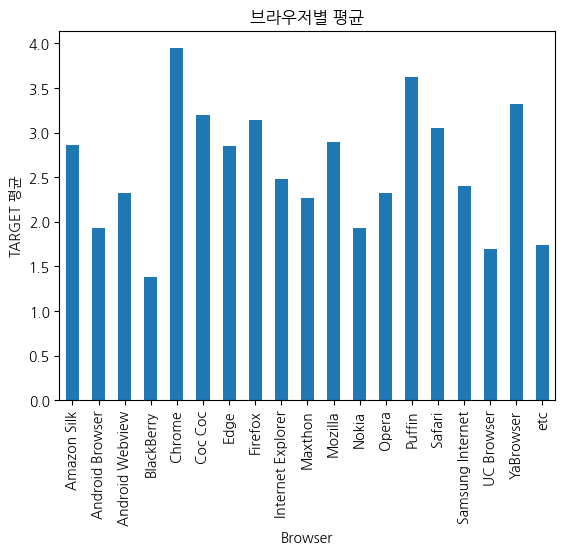

In [18]:
result.plot(kind='bar', xlabel='Browser', ylabel='TARGET 평균', title='브라우저별 평균')
plt.show()

In [19]:
for each in df:
    print(f'{each}의 가짓수:', df[each].nunique())

TARGET의 가짓수: 117
browser의 가짓수: 19
OS의 가짓수: 19
device의 가짓수: 3
new의 가짓수: 2
quality의 가짓수: 98
duration의 가짓수: 2972
bounced의 가짓수: 2
transaction의 가짓수: 8
transaction_revenue의 가짓수: 1218
continent의 가짓수: 6
subcontinent의 가짓수: 23
country의 가짓수: 205
traffic_source의 가짓수: 168
traffic_medium의 가짓수: 7
keyword의 가짓수: 623
referral_path의 가짓수: 1578


In [20]:
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252246.000000,252246.000000,252246.000000,252246.000000,252246.000000,252246.000000,2.522460e+05
mean,3.592731,0.751945,3.816643,113.096081,0.493657,0.009035,9.062793e+05
std,5.509765,0.431885,11.090797,330.858974,0.499961,0.100946,2.127870e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


In [21]:
df.isna().sum()

TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137633
referral_path          161088
dtype: int64

In [22]:
df['traffic_medium'].value_counts()

traffic_medium
organic      107369
referral      70024
(none)        59006
cpc            9978
affiliate      5362
cpm             501
(not set)         6
Name: count, dtype: int64

In [23]:
df[df['traffic_medium'] == 'organic'].isna().sum()

TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                  2685
referral_path          107369
dtype: int64

In [24]:
df[df['traffic_medium'] != 'organic'].isna().sum()

TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                134948
referral_path           53719
dtype: int64

In [25]:
df[df['traffic_medium'] == 'referral'].isna().sum()

TARGET                     0
browser                    0
OS                         0
device                     0
new                        0
quality                    0
duration                   0
bounced                    0
transaction                0
transaction_revenue        0
continent                  0
subcontinent               0
country                    0
traffic_source             0
traffic_medium             0
keyword                70024
referral_path              0
dtype: int64

In [26]:
df['referral_path'].value_counts()

referral_path
Category1               18686
Category3_Path_0013      7218
Category2_Path_0018      3985
Category6_Path_0008      3232
Category7_Path_0001      2984
                        ...  
Category2_Path_1096         1
Category11_Path_1089        1
Category11_Path_1088        1
Category4_Path_1086         1
Category6_Path_1576         1
Name: count, Length: 1578, dtype: int64

In [27]:
df['keyword'].value_counts()

keyword
Category8                103583
Category9                  3488
Category11                 1931
Category10                 1147
Category6_Keyword_003       634
                          ...  
Category2_Keyword_273         1
Category1_Keyword_271         1
Category3_Keyword_270         1
Category4_Keyword_269         1
Category4_Keyword_617         1
Name: count, Length: 623, dtype: int64

In [28]:
df.loc[df['traffic_medium'] == 'referral', 'referral_path'] = 1

# 'traffic_medium'가 'referral'이 아닌 행의 'referral_path' 값을 0으로 설정
df.loc[df['traffic_medium'] != 'referral', 'referral_path'] = 0

In [29]:
df_test.loc[df_test['traffic_medium'] == 'referral', 'referral_path'] = 1

# 'traffic_medium'가 'referral'이 아닌 행의 'referral_path' 값을 0으로 설정
df_test.loc[df_test['traffic_medium'] != 'referral', 'referral_path'] = 0

In [30]:
df['referral_path'].value_counts()

referral_path
0    182222
1     70024
Name: count, dtype: int64

In [31]:
df.isna().sum()

TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137633
referral_path               0
dtype: int64

In [32]:
df.loc[df['traffic_medium'] == 'referral', 'referral_path'] = 1

# 'traffic_medium'가 'referral'이 아닌 행의 'referral_path' 값을 0으로 설정
df.loc[df['traffic_medium'] != 'referral', 'referral_path'] = 0

In [33]:
df_test.loc[df_test['traffic_medium'] == 'referral', 'referral_path'] = 1

# 'traffic_medium'가 'referral'이 아닌 행의 'referral_path' 값을 0으로 설정
df_test.loc[df_test['traffic_medium'] != 'referral', 'referral_path'] = 0

In [34]:
df.loc[~df['traffic_medium'].isin(['organic', 'cpc']), 'keyword'] = 0

In [35]:
df_test.loc[~df_test['traffic_medium'].isin(['organic', 'cpc']), 'keyword'] = 0

In [36]:
df_test['keyword'].apply(lambda x: 0 if x == 'nan' else x)

0                0
1        Category8
2                0
3        Category8
4                0
           ...    
79781            0
79782    Category8
79783    Category8
79784    Category8
79785    Category8
Name: keyword, Length: 79786, dtype: object

In [37]:
df['keyword'].apply(lambda x: 0 if x == 'nan' else x)

0         Category8
1         Category8
2                 0
3                 0
4                 0
            ...    
252284            0
252285    Category8
252286            0
252287            0
252288            0
Name: keyword, Length: 252246, dtype: object

In [38]:
df.fillna(0, inplace=True)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_8676\4231983114.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


In [39]:
df_test.fillna(0, inplace=True)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_8676\2298550610.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.fillna(0, inplace=True)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252246 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252246 non-null  float64
 1   browser              252246 non-null  object 
 2   OS                   252246 non-null  object 
 3   device               252246 non-null  object 
 4   new                  252246 non-null  int64  
 5   quality              252246 non-null  float64
 6   duration             252246 non-null  float64
 7   bounced              252246 non-null  int64  
 8   transaction          252246 non-null  float64
 9   transaction_revenue  252246 non-null  float64
 10  continent            252246 non-null  object 
 11  subcontinent         252246 non-null  object 
 12  country              252246 non-null  object 
 13  traffic_source       252246 non-null  object 
 14  traffic_medium       252246 non-null  object 
 15  keyword              2

In [41]:
df.groupby('subcontinent')['TARGET'].mean()

subcontinent
(not set)             3.252976
Australasia           3.242105
Caribbean             3.184534
Central America       3.045227
Central Asia          3.158915
Eastern Africa        2.274809
Eastern Asia          3.205517
Eastern Europe        2.869735
Melanesia             3.000000
Micronesian Region    3.388889
Middle Africa         2.157895
Northern Africa       2.304120
Northern America      4.625277
Northern Europe       2.638154
Polynesia             4.125000
South America         2.972515
Southeast Asia        2.641912
Southern Africa       2.340111
Southern Asia         2.656901
Southern Europe       2.751930
Western Africa        2.130015
Western Asia          2.466067
Western Europe        2.855529
Name: TARGET, dtype: float64

In [42]:
os_counts = df['OS'].value_counts()

# 빈도수가 10개 이하인 값을 필터링하여 DataFrame 수정
df = df[df['OS'].isin(os_counts[os_counts > 10].index)]

In [43]:
df['OS'].value_counts()

OS
Windows          88109
Macintosh        60315
Android          51867
iOS              29775
Linux             9559
Chrome OS         9222
(not set)         2578
Tizen              321
Samsung            259
Windows Phone      126
OS/2                36
Xbox                31
BlackBerry          29
Name: count, dtype: int64

In [44]:
df['traffic_source'] = df['traffic_source'].apply(lambda x: 'google' if 'google' in x else x)

In [45]:
df_test['traffic_source'] = df_test['traffic_source'].apply(lambda x: 'google' if 'google' in x else x)

In [46]:
df['traffic_source'].value_counts()

traffic_source
google                     129276
(direct)                    59007
youtube.com                 52838
Partners                     5366
bing                          704
                            ...  
kidrex.org                      1
mail1.swic.edu                  1
lisham-web.blogspot.com         1
de.wow.com                      1
search.snapdo.com               1
Name: count, Length: 108, dtype: int64

In [47]:
traffic_counts = df['traffic_source'].value_counts()

# 빈도수가 10개 이하인 값을 필터링하여 DataFrame 수정
df = df[df['traffic_source'].isin(traffic_counts[traffic_counts > 10].index)]

In [48]:
def traffic_total(x):
    if 'yahoo' in x:
        return 'yahoo'
    if 'facebook' in x:
        return 'facebook'
    if 'baidu' in x:
        return 'baidu'
    else:
        return x

In [49]:
df['traffic_source'] = df['traffic_source'].apply(lambda x: traffic_total(x))

In [50]:
df_test['traffic_source'] = df_test['traffic_source'].apply(lambda x: traffic_total(x))

In [51]:
df['transaction_revenue'].describe()

count    2.520490e+05
mean     9.069876e+05
std      2.128700e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.325712e+09
Name: transaction_revenue, dtype: float64

In [52]:
for each in df:
    print(f'{each}의 가짓수:', df[each].nunique())

TARGET의 가짓수: 117
browser의 가짓수: 19
OS의 가짓수: 13
device의 가짓수: 3
new의 가짓수: 2
quality의 가짓수: 98
duration의 가짓수: 2972
bounced의 가짓수: 2
transaction의 가짓수: 8
transaction_revenue의 가짓수: 1218
continent의 가짓수: 6
subcontinent의 가짓수: 23
country의 가짓수: 205
traffic_source의 가짓수: 32
traffic_medium의 가짓수: 7
keyword의 가짓수: 620
referral_path의 가짓수: 2


In [53]:
columns_diff = set(df.columns) - set(df_test.columns)
if columns_diff:
    print(f"Differences in column names:")
    print(columns_diff)
    print('\n')
else:
    print("No differences in column names.\n")

Differences in column names:
{'TARGET'}




## Feature Importance를 확인해보자

In [54]:
X['keyword'] = X['keyword'].apply(lambda x: 1 if x != 0 else 0)

NameError: name 'X' is not defined

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
X = df.drop(['TARGET', 'country'], axis=1)
X['keyword'] = X['keyword'].apply(lambda x: 1 if x != 0 else 0)
df_test['keyword'] = df_test['keyword'].apply(lambda x: 1 if x != 0 else 0)
X_test = df_test.drop('country', axis=1)

encoding_target = list(X.dtypes[X.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    le.fit(X[i])
    X[i] = le.transform(X[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    # test 데이터에 대해서 직접적으로 fit을 수행할 경우 Data Leakage
    for case in np.unique(X_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    
    X_test[i] = le.transform(X_test[i])
y = df['TARGET']


In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   browser              79786 non-null  object 
 1   OS                   79786 non-null  object 
 2   device               79786 non-null  object 
 3   new                  79786 non-null  int64  
 4   quality              79786 non-null  float64
 5   duration             79786 non-null  float64
 6   bounced              79786 non-null  int64  
 7   transaction          79786 non-null  float64
 8   transaction_revenue  79786 non-null  float64
 9   continent            79786 non-null  object 
 10  subcontinent         79786 non-null  object 
 11  country              79786 non-null  object 
 12  traffic_source       79786 non-null  object 
 13  traffic_medium       79786 non-null  object 
 14  keyword              79786 non-null  int64  
 15  referral_path        79786 non-null 

In [58]:
categorical_features = list(X.dtypes[X.dtypes == "object"].index)

for i in categorical_features:
    count = X[i].nunique()  # 고유값의 개수를 계산
    print(f"{i}: {count}")

In [59]:
columns_diff = set(X.columns) - set(X_test.columns)
if columns_diff:
    print(f"Differences in column names:")
    print(columns_diff)
    print('\n')
else:
    print("No differences in column names.\n")

No differences in column names.



In [60]:
X_train = X.drop(columns=list(columns_diff), errors='ignore')

## RandomForestRegressor

* 결과: 3.09

In [61]:
# RandomForest 모델 생성
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y)
pred_rf = rf_model.predict(X_test)
# Feature Importance 확인
feature_importances = rf_model.feature_importances_

In [62]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# 내림차순 정렬
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# 정렬된 Feature Importance 출력
print(sorted_feature_importances)

quality                0.536494
duration               0.288290
continent              0.030628
subcontinent           0.027338
OS                     0.019655
new                    0.015739
browser                0.013843
traffic_source         0.013797
device                 0.013453
transaction_revenue    0.012102
keyword                0.009060
traffic_medium         0.009041
transaction            0.008322
referral_path          0.002217
bounced                0.000022
dtype: float64


In [63]:
submission = pd.read_csv('./sample_submission.csv')
submission

,sessionID,TARGET
0,SESSION_252289,0
1,SESSION_252290,0
2,SESSION_252291,0
3,SESSION_252292,0
4,SESSION_252293,0
...,...,...
79781,SESSION_332070,0
79782,SESSION_332071,0
79783,SESSION_332072,0
79784,SESSION_332073,0


In [64]:
submission['TARGET'] = pred_rf
submission

,sessionID,TARGET
0,SESSION_252289,22.700000
1,SESSION_252290,1.000000
2,SESSION_252291,1.670071
3,SESSION_252292,3.565008
4,SESSION_252293,12.140000
...,...,...
79781,SESSION_332070,1.000000
79782,SESSION_332071,1.000000
79783,SESSION_332072,2.831667
79784,SESSION_332073,4.506579


In [65]:
submission.to_csv('./rf_submission.csv', index=False)

## CatBoostRegressor

* 결과: 2.98

In [66]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(['TARGET', 'country'], axis=1)
X['keyword'] = X['keyword'].apply(lambda x: 1 if x != 0 else 0)

X_test = df_test.drop(['country'], axis=1)

encoding_target = list(X.dtypes[X.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    le.fit(X[i])
    X[i] = le.transform(X[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    # test 데이터에 대해서 직접적으로 fit을 수행할 경우 Data Leakage
    for case in np.unique(X_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    
    X_test[i] = le.transform(X_test[i])
y = df['TARGET']

In [67]:
catboost_model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', random_seed=42)
catboost_model.fit(X, y, cat_features=encoding_target, early_stopping_rounds=50, verbose=100)

# 예측
y_pred = catboost_model.predict(X_test)


0:	learn: 5.1707148	total: 253ms	remaining: 4m 12s
100:	learn: 2.7054921	total: 8.8s	remaining: 1m 18s
200:	learn: 2.6047976	total: 17.2s	remaining: 1m 8s
300:	learn: 2.5440837	total: 25.6s	remaining: 59.5s
400:	learn: 2.4876631	total: 34s	remaining: 50.8s
500:	learn: 2.4447621	total: 42.9s	remaining: 42.7s
600:	learn: 2.4110028	total: 51.9s	remaining: 34.5s
700:	learn: 2.3765538	total: 1m	remaining: 25.6s
800:	learn: 2.3529262	total: 1m 9s	remaining: 17.1s
900:	learn: 2.3370359	total: 1m 17s	remaining: 8.54s
999:	learn: 2.3225490	total: 1m 26s	remaining: 0us


In [68]:
# RandomForest 모델 생성
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
pred_rf = rf_model.predict(X_test)
# Feature Importance 확인
feature_importances = rf_model.feature_importances_

In [69]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# 내림차순 정렬
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# 정렬된 Feature Importance 출력
print(sorted_feature_importances)

quality                0.536151
duration               0.289954
continent              0.030731
subcontinent           0.027138
OS                     0.019427
new                    0.015663
traffic_source         0.014033
device                 0.013556
browser                0.013314
transaction_revenue    0.011643
traffic_medium         0.009198
keyword                0.008481
transaction            0.008471
referral_path          0.002170
bounced                0.000071
dtype: float64


In [70]:
submission['TARGET'] = pred_rf
submission.to_csv('./rf2_submission.csv', index=False)

In [71]:
submission['TARGET'] = y_pred
submission.to_csv('./cat_submission.csv', index=False)

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
# 모델 리스트
models = [
    ('GradientBoostingRegressor', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }),
    ('Lasso', Lasso(), {
        'alpha': [0.001, 0.01, 0.1, 1.0]
    }),
    ('LinearRegression', LinearRegression(), {}),
    ('XGBRegressor', XGBRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    })
]

# 예측값 저장을 위한 데이터프레임 생성
predictions_df = pd.DataFrame()

# 모델 선택 및 튜닝
for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y)
    
    # 최적의 모델 및 파라미터 출력
    print(f"{model_name}: Best Parameters - {grid_search.best_params_}")

    # 테스트 데이터에 모델 적용 및 예측값 저장
    y_pred = grid_search.predict(X_test)
    predictions_df[model_name] = y_pred

GradientBoostingRegressor: Best Parameters - {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Lasso: Best Parameters - {'alpha': 0.01}
LinearRegression: Best Parameters - {}
XGBRegressor: Best Parameters - {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [73]:
predictions_df

,GradientBoostingRegressor,Lasso,LinearRegression,XGBRegressor
0,22.425712,23.088980,22.729175,23.229046
1,1.011364,0.980087,0.991305,1.004129
2,2.805629,3.777926,3.798509,2.733693
3,4.315431,4.641307,4.721083,4.281978
4,12.689715,5.839613,5.877080,12.140450
...,...,...,...,...
79781,1.032623,1.048194,1.164320,1.017867
79782,1.048117,1.383427,1.375584,1.018384
79783,2.779208,4.632874,4.706506,2.710551
79784,5.114735,4.921973,4.987270,5.037055


In [74]:
submission['TARGET'] = predictions_df['XGBRegressor']
submission.to_csv('./XGB_submission.csv', index=False)

In [75]:
submission['TARGET'] = predictions_df['LinearRegression']
submission.to_csv('./lr_submission.csv', index=False)